# classification-29

## What's new:

1- change labeling strategies


## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, Dropout
from tensorflow.keras import Input, layers, models, callbacks, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from tensorflow.keras.optimizers import Adam
import joblib
import json
from datetime import datetime, timedelta
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-12-28 20:51:55.441453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-28 20:51:55.532121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

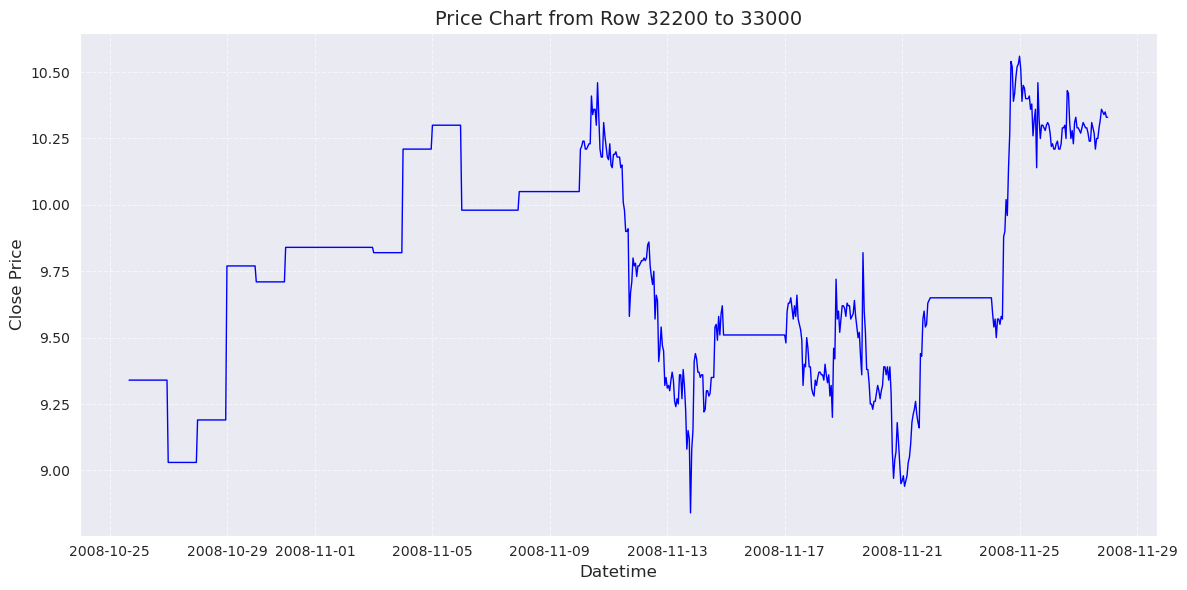

In [4]:
# 2- Find start of dataset
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# 3- Select the rows required for the model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [19]:
# 4- label_reversal_points Function
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,
        min_dev_sigma=2.0,
        vol_window=100,
        verbose=False
):
    import numpy as np
    from scipy.signal import savgol_filter, find_peaks, peak_prominences

    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # -------------------------------------------------------
    # NaN handling
    # -------------------------------------------------------
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # -------------------------------------------------------
    # EMA helper
    # -------------------------------------------------------
    def ema(x, span):
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close

    # -------------------------------------------------------
    # Smoothing
    # -------------------------------------------------------
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i])))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i])))

    candidates.sort(key=lambda x: x[0])

    if not candidates:
        return np.zeros(n, dtype=int)

    # -------------------------------------------------------
    # Enforce alternation
    # -------------------------------------------------------
    def enforce_alternation(ext):
        ext = ext[:]
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # -------------------------------------------------------
    # Snap extrema
    # -------------------------------------------------------
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            return L + (np.argmax(high[L:R]) if typ == 2 else np.argmin(low[L:R]))
        return L + (np.argmax(close[L:R]) if typ == 2 else np.argmin(close[L:R]))

    snapped = {}
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        if (j, typ) not in snapped or pr > snapped[(j, typ)][2]:
            snapped[(j, typ)] = (j, typ, pr)

    snapped = enforce_alternation(sorted(snapped.values(), key=lambda x: x[0]))

    # -------------------------------------------------------
    # Prune micro-legs
    # -------------------------------------------------------
    final_ext = []
    for idx, typ, pr in snapped:
        if not final_ext:
            final_ext.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = final_ext[-1]
        leg = abs(close[idx] - close[prev_idx])
        thr = max(
            min_dev_pct * close[idx],
            min_dev_sigma * max(local_vol_price[idx], 1e-12)
        )
        if leg >= thr:
            final_ext.append((idx, typ, pr))

    # =======================================================
    # 🔥 NEW PART: TREND GAP FILLING
    # =======================================================
    labels = np.zeros(n, dtype=int)

    for i in range(len(final_ext) - 1):
        idx0, typ0, _ = final_ext[i]
        idx1, typ1, _ = final_ext[i + 1]

        labels[idx0] = typ0

        if typ0 == 1 and typ1 == 2:
            labels[idx0:idx1] = 1  # bullish leg
        elif typ0 == 2 and typ1 == 1:
            labels[idx0:idx1] = 2  # bearish leg

    # -------------------------------------------------------
    # EXTEND LAST TREND TO THE END (critical fix)
    # -------------------------------------------------------
    if final_ext:
        last_idx, last_typ, _ = final_ext[-1]

    if last_idx < n - 1:
        if last_typ == 1:
            labels[last_idx:] = 1  # bullish continuation
        elif last_typ == 2:
            labels[last_idx:] = 2  # bearish continuation

    if verbose:
        print("Label counts:",
              {k: int((labels == k).sum()) for k in [0, 1, 2]})
        print("Extrema kept:", len(final_ext))

    return labels


In [7]:
# 5- baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [20]:
# 5- baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

Label counts: {0: 544, 1: 76697, 2: 69115}
Extrema kept: 2140
Label
1    76697
2    69115
0      544
Name: count, dtype: int64


In [8]:
# 6- Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [21]:
# 6- Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")

Label Distribution in df_model:
----------------------------------------
Class 0: 544 rows (0.37%)
Class 1: 76,697 rows (52.40%)
Class 2: 69,115 rows (47.22%)
----------------------------------------
Total rows: 146,356


In [22]:
# 7- Plot labels
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



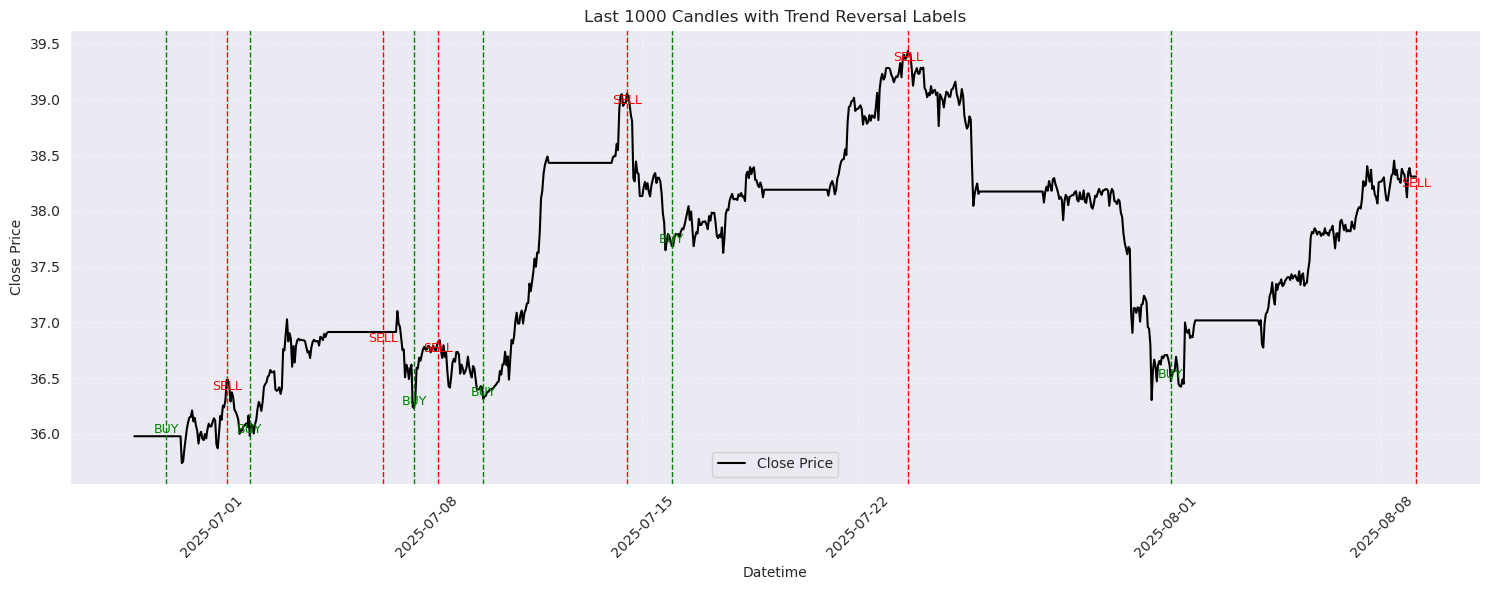

In [10]:
plot_labeled_candles(df_model)

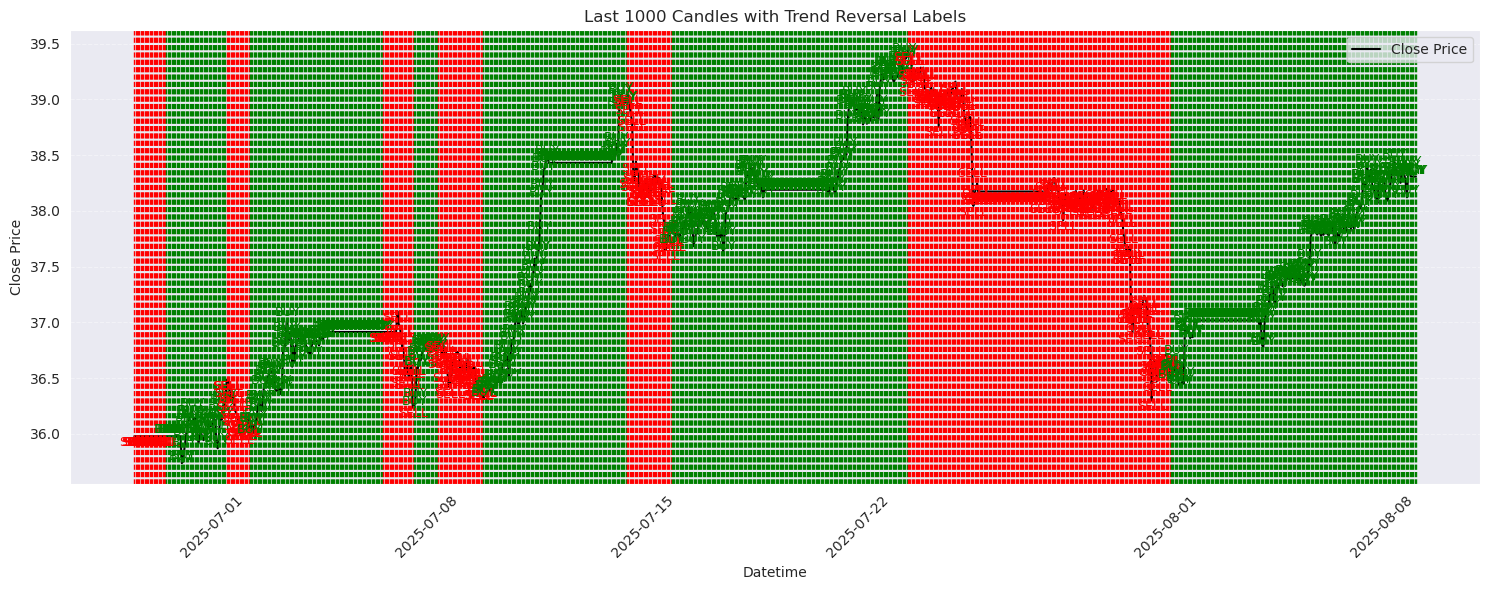

In [23]:
plot_labeled_candles(df_model)

In [11]:
# 8- PART 2 — CHRONOLOGICAL SPLITTING

# ----------------------------
# Configuration
# ----------------------------
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
LABEL_COL = 'Label'

# ----------------------------
# Sanity checks
# ----------------------------
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, "Split ratios must sum to 1"
assert LABEL_COL in df_model.columns, "Label column missing"
for f in FEATURES:
    assert f in df_model.columns, f"Feature '{f}' missing"

# Ensure strict chronological order
df_model = df_model.sort_values('DATETIME').reset_index(drop=True)

# ----------------------------
# Compute split indices
# ----------------------------
n_total = len(df_model)

train_end = int(n_total * TRAIN_RATIO)
val_end = train_end + int(n_total * VAL_RATIO)

# ----------------------------
# Chronological split
# ----------------------------
df_train = df_model.iloc[:train_end].copy()
df_val = df_model.iloc[train_end:val_end].copy()
df_test = df_model.iloc[val_end:].copy()

# ----------------------------
# Separate features and labels
# (to be used in PART 3: Scaling)
# ----------------------------
X_train_df = df_train[FEATURES].copy()
y_train_df = df_train[LABEL_COL].copy()

X_val_df = df_val[FEATURES].copy()
y_val_df = df_val[LABEL_COL].copy()

X_test_df = df_test[FEATURES].copy()
y_test_df = df_test[LABEL_COL].copy()

# ----------------------------
# Print outputs required for PART 3
# ----------------------------
print("=== CHRONOLOGICAL SPLIT COMPLETED ===\n")

print("Rows:")
print(f"Train: {len(df_train)}")
print(f"Val  : {len(df_val)}")
print(f"Test : {len(df_test)}\n")

print("Feature matrices (for scaling):")
print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_val_df   shape: {X_val_df.shape}")
print(f"X_test_df  shape: {X_test_df.shape}\n")

print("Label vectors:")
print(f"y_train_df shape: {y_train_df.shape}")
print(f"y_val_df   shape: {y_val_df.shape}")
print(f"y_test_df  shape: {y_test_df.shape}\n")

print("Variables available for PART 3:")
print("X_train_df, X_val_df, X_test_df")
print("y_train_df, y_val_df, y_test_df")


=== CHRONOLOGICAL SPLIT COMPLETED ===

Rows:
Train: 102449
Val  : 21953
Test : 21954

Feature matrices (for scaling):
X_train_df shape: (102449, 5)
X_val_df   shape: (21953, 5)
X_test_df  shape: (21954, 5)

Label vectors:
y_train_df shape: (102449,)
y_val_df   shape: (21953,)
y_test_df  shape: (21954,)

Variables available for PART 3:
X_train_df, X_val_df, X_test_df
y_train_df, y_val_df, y_test_df


In [12]:
# 9- PART 3: FEATURE SCALING

from sklearn.preprocessing import StandardScaler

# ----------------------------
# Initialize scaler
# ----------------------------
scaler = StandardScaler()

# ----------------------------
# Fit ONLY on training data
# ----------------------------
X_train_scaled = scaler.fit_transform(X_train_df)

# ----------------------------
# Transform validation & test
# ----------------------------
X_val_scaled = scaler.transform(X_val_df)
X_test_scaled = scaler.transform(X_test_df)

# ----------------------------
# Convert labels to NumPy arrays
# (important for sequence creation)
# ----------------------------
y_train = y_train_df.values
y_val = y_val_df.values
y_test = y_test_df.values

# ----------------------------
# Convert scaled features to NumPy arrays
# ----------------------------
X_train = np.asarray(X_train_scaled, dtype=np.float32)
X_val = np.asarray(X_val_scaled, dtype=np.float32)
X_test = np.asarray(X_test_scaled, dtype=np.float32)

# ============================
# OUTPUT FOR PART 4
# ============================
print("\n=== SCALING COMPLETED ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_val   shape: {X_val.shape}")
print(f"X_test  shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_val   shape: {y_val.shape}")
print(f"y_test  shape: {y_test.shape}")

print("\nVariables ready for PART 4:")
print("X_train, y_train")
print("X_val, y_val")
print("X_test, y_test")



=== SCALING COMPLETED ===
X_train shape: (102449, 5)
X_val   shape: (21953, 5)
X_test  shape: (21954, 5)
y_train shape: (102449,)
y_val   shape: (21953,)
y_test  shape: (21954,)

Variables ready for PART 4:
X_train, y_train
X_val, y_val
X_test, y_test


In [13]:
# 10- PART 4 — CREATE SEQUENCES (WINDOW_SIZE → X, FORECAST_HORIZON → y)

WINDOW_SIZE = 120
FORECAST_HORIZON = 5


# ------------------------------------------------------------
# Sequence creation function (time-series safe, no shuffling)
# ------------------------------------------------------------
def create_sequences(X, y, window_size, forecast_horizon):
    """
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
    y : np.ndarray, shape (n_samples,)
    window_size : int
    forecast_horizon : int

    Returns
    -------
    X_seq : np.ndarray, shape (n_sequences, window_size, n_features)
    y_seq : np.ndarray, shape (n_sequences, forecast_horizon)
    """
    X_seq = []
    y_seq = []

    max_start = len(X) - window_size - forecast_horizon + 1

    for i in range(max_start):
        X_seq.append(X[i: i + window_size])
        y_seq.append(y[i + window_size: i + window_size + forecast_horizon])

    return np.array(X_seq), np.array(y_seq)


# ------------------------------------------------------------
# Create sequences for train / validation / test
# ------------------------------------------------------------
X_train_seq, y_train_seq = create_sequences(
    X_train, y_train, WINDOW_SIZE, FORECAST_HORIZON
)

X_val_seq, y_val_seq = create_sequences(
    X_val, y_val, WINDOW_SIZE, FORECAST_HORIZON
)

X_test_seq, y_test_seq = create_sequences(
    X_test, y_test, WINDOW_SIZE, FORECAST_HORIZON
)

# ------------------------------------------------------------
# Sanity checks
# ------------------------------------------------------------
assert X_train_seq.shape[0] == y_train_seq.shape[0]
assert X_val_seq.shape[0] == y_val_seq.shape[0]
assert X_test_seq.shape[0] == y_test_seq.shape[0]

assert X_train_seq.shape[1] == WINDOW_SIZE
assert y_train_seq.shape[1] == FORECAST_HORIZON

# ============================================================
# OUTPUT VARIABLES REQUIRED FOR PART 5 (IMBALANCE HANDLING)
# ============================================================
print("=== SEQUENCE DATASETS READY ===")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")

print(f"X_val_seq   shape: {X_val_seq.shape}")
print(f"y_val_seq   shape: {y_val_seq.shape}")

print(f"X_test_seq  shape: {X_test_seq.shape}")
print(f"y_test_seq  shape: {y_test_seq.shape}")

# Variables exposed for PART 5:
# X_train_seq, y_train_seq
# X_val_seq, y_val_seq
# X_test_seq, y_test_seq


=== SEQUENCE DATASETS READY ===
X_train_seq shape: (102325, 120, 5)
y_train_seq shape: (102325, 5)
X_val_seq   shape: (21829, 120, 5)
y_val_seq   shape: (21829, 5)
X_test_seq  shape: (21830, 120, 5)
y_test_seq  shape: (21830, 5)


In [14]:
# 11- PART 5 — IMBALANCE HANDLING (Class-Weighted)

# Rules enforced:
#   - NO oversampling / undersampling / SMOTE
#   - Class-weighted loss ONLY
#   - Weights computed from y_train_seq ONLY
# ============================================================

from sklearn.utils.class_weight import compute_class_weight

# ------------------------------------------------------------
# y_train_seq shape: (num_samples, FORECAST_HORIZON)
# We must compute class weights from ALL future labels
# ------------------------------------------------------------

# Flatten all forecast steps into one long label vector
y_train_flat = y_train_seq.reshape(-1)

# Unique classes (must be [0,1,2])
classes = np.unique(y_train_flat)

# Compute balanced class weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_flat
)

# Convert to Keras-compatible dict
class_weights = {int(cls): float(w) for cls, w in zip(classes, weights)}

# ------------------------------------------------------------
# Sanity checks
# ------------------------------------------------------------
print("=== CLASS DISTRIBUTION (TRAIN ONLY) ===")
unique, counts = np.unique(y_train_flat, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

print("\n=== CLASS WEIGHTS (Keras compatible) ===")
for k, v in class_weights.items():
    print(f"Class {k}: {v:.4f}")

# ============================================================
# VARIABLES REQUIRED FOR PART 6
# ============================================================
print("\n=== VARIABLES READY FOR PART 6 ===")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq   shape: {X_val_seq.shape}")
print(f"y_val_seq   shape: {y_val_seq.shape}")
print(f"X_test_seq  shape: {X_test_seq.shape}")
print(f"y_test_seq  shape: {y_test_seq.shape}")
print("class_weights:", class_weights)


=== CLASS DISTRIBUTION (TRAIN ONLY) ===
Class 0: 504935 samples
Class 1: 3345 samples
Class 2: 3345 samples

=== CLASS WEIGHTS (Keras compatible) ===
Class 0: 0.3377
Class 1: 50.9841
Class 2: 50.9841

=== VARIABLES READY FOR PART 6 ===
X_train_seq shape: (102325, 120, 5)
y_train_seq shape: (102325, 5)
X_val_seq   shape: (21829, 120, 5)
y_val_seq   shape: (21829, 5)
X_test_seq  shape: (21830, 120, 5)
y_test_seq  shape: (21830, 5)
class_weights: {0: 0.33774974336630786, 1: 50.98405580468361, 2: 50.98405580468361}


In [15]:
# 12- PART 6 — Build and Train the Model

# ============================================================
# Hyperparameters
# ============================================================
NUM_CLASSES = 3
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# ============================================================
# Class weights (from PART 5)
# ============================================================
# class_weights = {0: 0.3377, 1: 50.9841, 2: 50.9841}

class_weight_tensor = tf.constant(
    [class_weights[0], class_weights[1], class_weights[2]],
    dtype=tf.float32
)


# ============================================================
# Custom weighted sparse categorical cross-entropy
# (supports multi-step sequence targets)
# ============================================================
@tf.keras.utils.register_keras_serializable()
def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    """
    y_true: (batch, horizon)
    y_pred: (batch, horizon, num_classes)
    """
    y_true = tf.cast(y_true, tf.int32)

    # Standard sparse categorical cross-entropy per timestep
    scce = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=False
    )  # shape: (batch, horizon)

    # Gather class weights for each true label
    weights = tf.gather(class_weight_tensor, y_true)  # (batch, horizon)

    # Apply weights
    weighted_loss = scce * weights

    return tf.reduce_mean(weighted_loss)


I0000 00:00:1766749296.098021    3542 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2374 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [16]:
# Model Architecture (Encoder → Sequence Classifier)

inputs = layers.Input(shape=(WINDOW_SIZE, len(FEATURES)))

x = layers.LSTM(
    128,
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.2
)(inputs)

x = layers.LSTM(
    64,
    return_sequences=False,
    dropout=0.2,
    recurrent_dropout=0.2
)(x)

# Project to forecast horizon
x = layers.Dense(FORECAST_HORIZON * 64, activation="relu")(x)
x = layers.Reshape((FORECAST_HORIZON, 64))(x)

# Time-distributed classification head
outputs = layers.TimeDistributed(
    layers.Dense(NUM_CLASSES, activation="softmax")
)(x)

model = models.Model(inputs, outputs)

In [17]:
# Compile

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=weighted_sparse_categorical_crossentropy,
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 120, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 3)           │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,011 (543.01 KB)

 Trainable params: 139,011 (543.01 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks

cb_early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [19]:
# Train

history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=BATCH_SIZE,
    callbacks=[cb_early_stop, cb_reduce_lr],
    verbose=1
)
print("\nTRAINING COMPLETE!")

Epoch 1/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 226s 274ms/step - accuracy: 0.4865 - loss: 1.0914 - val_accuracy: 0.4982 - val_loss: 1.3716 - learning_rate: 0.0010
Epoch 2/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 217s 271ms/step - accuracy: 0.4057 - loss: 1.0813 - val_accuracy: 0.2260 - val_loss: 1.3549 - learning_rate: 0.0010
Epoch 3/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 217s 271ms/step - accuracy: 0.4218 - loss: 1.0738 - val_accuracy: 0.2019 - val_loss: 1.3476 - learning_rate: 0.0010
Epoch 4/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 215s 269ms/step - accuracy: 0.4299 - loss: 1.0725 - val_accuracy: 0.2224 - val_loss: 1.3445 - learning_rate: 0.0010
Epoch 5/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 221s 277ms/step - accuracy: 0.4194 - loss: 1.0718 - val_accuracy: 0.1666 - val_loss: 1.4022 - learning_rate: 0.0010
Epoch 6/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 228s 285ms/step - accuracy: 0.5001 - loss: 1.0849 - val_accuracy: 0.2983 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 7/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 235s 293ms/step -

# Save Model, Scaler and Report section

In [20]:
# 1- Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

In [21]:
# 2- Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [22]:
# 3- Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")


[SAVING MODEL]
Model saved to: saved_models/model_20251226_170316.keras


In [23]:
# 4- Save scaler (IMPORTANT - needed for predictions!)

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

Scaler saved to: saved_models/scaler_20251226_170316.pkl


In [24]:
# 5- Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

Training history saved


In [25]:
# 6- Save full history as JSON so it can be reloaded later
history_json_path = os.path.join(log_dir, 'history.json')
with open(history_json_path, 'w') as f:
    json.dump(history.history, f)

print(f"Full history object saved to: {history_json_path}")

Full history object saved to: saved_models/model_20251226_170316_logs/history.json


In [26]:
# 7— Save Training Loss Plot

loss_plot_path = os.path.join(log_dir, "training_loss.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(loss_plot_path)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

Loss plot saved to: saved_models/model_20251226_170316_logs/training_loss.png


In [27]:
# 8— Save Accuracy Plot
acc_plot_path = os.path.join(log_dir, "training_accuracy.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['accuracy'], label='Val Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(acc_plot_path)
plt.close()

print(f"Accuracy plot saved to: {acc_plot_path}")

Accuracy plot saved to: saved_models/model_20251226_170316_logs/training_accuracy.png


In [28]:
# 9- Save model summary and final performance

# ============================
# Evaluate once
# ============================
final_test_loss, final_test_acc = model.evaluate(
    X_test_seq,
    y_test_seq,
    verbose=1
)

final_train_loss = history.history['loss'][-1]

# ============================
# Save model summary and metrics
# ============================
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

    f.write('\n=== FINAL PERFORMANCE ===\n')
    f.write(f'Final Training Loss : {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss     : {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy : {final_test_acc:.6f}\n')

683/683 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - accuracy: 0.2839 - loss: 1.2550


In [29]:
# 10- Confusion matrix

# Flatten horizon dimension
y_test_pred = model.predict(X_test_seq, batch_size=BATCH_SIZE)
y_test_pred_labels = y_test_pred.argmax(axis=-1)

y_true_flat = y_test_seq.reshape(-1)
y_pred_flat = y_test_pred_labels.reshape(-1)

# Confusion matrix (flattened)
cm = confusion_matrix(y_true_flat, y_pred_flat)

print('\nConfusion matrix (flattened timesteps):')
print(cm)

# Path to save
cm_plot_path = os.path.join(log_dir, "confusion_matrix.png")

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['0', '1', '2'],
    yticklabels=['0', '1', '2']
)
plt.title("Confusion Matrix (Flattened Horizon)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(cm_plot_path)
plt.close()

print(f"Confusion matrix saved to: {cm_plot_path}")


171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step

Confusion matrix (flattened timesteps):
[[30067 10205 66982]
 [   39   172   739]
 [   55   142   749]]
Confusion matrix saved to: saved_models/model_20251226_170316_logs/confusion_matrix.png


In [30]:
# PREDICTION SECTION
N_FEATURES = len(FEATURES)  # 5

print("\n" + "=" * 80)
print("PREDICTION ON UNSEEN DATA")
print("=" * 80)

# If given_time already exists, add 5 hours
try:
    dt = datetime.strptime(given_time, "%Y.%m.%d %H:%M:%S") + timedelta(hours=5)
except NameError:
    # First run: initialize given_time
    dt = datetime.strptime("2025.08.13 21:00:00", "%Y.%m.%d %H:%M:%S")

# Store back as string
given_time = dt.strftime("%Y.%m.%d %H:%M:%S")
print(f"\nGiven time: {given_time}")


PREDICTION ON UNSEEN DATA

Given time: 2025.08.13 21:00:00


In [31]:
# Find the index of given_time in df (not df_model)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
given_idx = df[df['DATETIME'] == given_time].index[0]

print(f"Given time index in df: {given_idx}")

# Extract 120 candles ending at given_time
start_idx = given_idx - WINDOW_SIZE + 1
end_idx = given_idx + 1

input_df = df.iloc[start_idx:end_idx][['DATETIME'] + FEATURES].copy()
print(f"Input shape (before scaling): {input_df.shape}")

# Separate DATETIME from features for scaling
input_candles = input_df.copy()  # Keep for visualization (has DATETIME)
input_features_only = input_df[FEATURES]  # Only features for model

# Scale using the same scaler from training (only the FEATURES columns)
input_scaled = scaler.transform(input_features_only)
input_scaled = input_scaled.reshape(1, WINDOW_SIZE, N_FEATURES)

# Predict
predictions_proba = model.predict(input_scaled, verbose=0)  # Shape: (1, 10, 3)
predictions_proba = predictions_proba[0]  # Shape: (10, 3)

# Get predicted classes
predicted_classes = np.argmax(predictions_proba, axis=1)

# Create forecast datetimes (next 10 hours after given_time)
given_datetime = pd.to_datetime(given_time)
forecast_datetimes = [given_datetime + pd.Timedelta(hours=i + 1) for i in range(FORECAST_HORIZON)]

# Create output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': predicted_classes,
    'prob_0': predictions_proba[:, 0],
    'prob_1': predictions_proba[:, 1],
    'prob_2': predictions_proba[:, 2]
})

print("\n" + "=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)
predicted_df

Given time index in df: 179469
Input shape (before scaling): (120, 6)

PREDICTION RESULTS


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-13 22:00:00,2,0.206420,0.381056,0.412524
1,2025-08-13 23:00:00,2,0.217655,0.376065,0.406280
2,2025-08-14 00:00:00,2,0.212657,0.380147,0.407196
3,2025-08-14 01:00:00,2,0.200413,0.392414,0.407174
4,2025-08-14 02:00:00,2,0.202705,0.396709,0.400587


# plot section

In [32]:
historical_df = input_df.tail(2).copy()

In [33]:
historical_df

,DATETIME,OPEN,HIGH,LOW,CLOSE,TICKVOL
179468,2025-08-13 20:00:00,38.483,38.572,38.468,38.479,1006.0
179469,2025-08-13 21:00:00,38.480,38.487,38.440,38.476,897.0


In [34]:
# Actual future 10 candles
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()

In [35]:
actual_future_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
179469,2025-08-13 21:00:00,2025.08.13,21:00:00,38.480,38.487,38.440,38.476,897.0,0.0,11.0
179470,2025-08-13 22:00:00,2025.08.13,22:00:00,38.476,38.549,38.456,38.539,856.0,0.0,11.0
179471,2025-08-13 23:00:00,2025.08.13,23:00:00,38.526,38.541,38.483,38.493,419.0,0.0,14.0
179472,2025-08-14 00:00:00,NaN,NaN,38.526,38.541,38.483,38.493,0.0,0.0,14.0
179473,2025-08-14 01:00:00,2025.08.14,01:00:00,38.533,38.538,38.506,38.519,395.0,0.0,21.0
179474,2025-08-14 02:00:00,2025.08.14,02:00:00,38.514,38.532,38.487,38.518,522.0,0.0,21.0


In [36]:
# Add text labels for clarity
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'


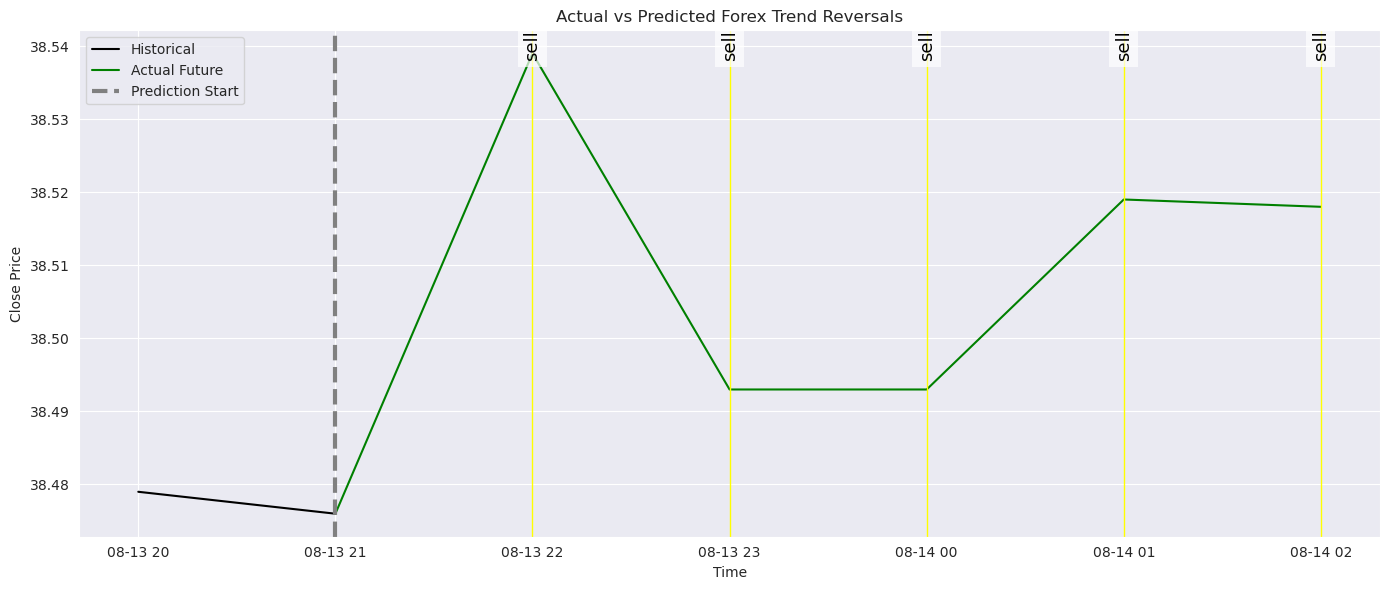

In [37]:
# Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


# Load section

In [ ]:
# 1- Load model
model_path = 'saved_models/model_20251226_170316.keras'
model = keras.models.load_model(model_path)

# 2- Load scaler
scaler_path = 'saved_models/scaler_20251226_170316.pkl'
scaler = joblib.load(scaler_path)

# 3- Load history JSON
log_dir = 'saved_models/model_20251226_170316_logs'
history_json_path = os.path.join(log_dir, 'history.json')

with open(history_json_path, 'r') as f:
    history_dict = json.load(f)


# create history-like object
class ReloadedHistory:
    def __init__(self, hdict):
        self.history = hdict


history = ReloadedHistory(history_dict)

# Now you can access history just like before
print(history.history.keys())
print(history.history['loss'][:5])
